In [75]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import uszipcode
from uszipcode import SearchEngine
import seaborn as sns

In [76]:
data_path = '/Users/ameliabaum/Desktop/Amelia/Berkeley Fall 2019/CY PLAN 257/Final Project/data/'
notebooks_path = '/Users/ameliabaum/Desktop/Amelia/Berkeley Fall 2019/CY PLAN 257/Final Project/notebooks/'

## Load in test data. 
Filtered by valid zip codes and marked as being in bay or in la

In [77]:
test_data = pd.read_csv(data_path+"test_with_regions.csv")
test_data.head()

,Unnamed: 0,HHPER,RELAT,GEND,AGE,HISP,RACE1,HHPERPLA,MODE,ARR_HR,...,PERNO,PLANO,APURP,STIME,ETIME,TSERIES_NUM,is_zip,is_bay,is_la,ORIGIN_ZIP
0,100727,14510811,1,2,44,1,97.0,145108111,NaN,3,...,1,1,2,03:00,02:59,2,True,False,False,NaN
1,237510,18468443,3,2,22,2,1.0,184684433,10.0,19,...,3,3,38,19:30,23:00,1,True,False,True,NaN
2,88229,14254664,3,1,9,2,1.0,142546641,NaN,3,...,4,1,1,03:00,08:00,1,True,True,False,NaN
3,137154,15223912,2,1,62,2,1.0,152239121,NaN,3,...,2,1,1,03:00,02:59,1,True,True,False,NaN
4,597738,71935771,1,1,28,2,1.0,7193577110,5.0,13,...,1,10,1,15:00,02:59,3,True,True,False,94609.0


In [78]:
la_data = test_data[test_data["is_la"] == True]
bay_data = test_data[test_data["is_bay"] == True]

In [79]:

def get_features(df):
    '''The get features function as a whole will calculate inbound or outbound trips based on the 
    column that the groupby is called on. Using "ZIP" will count inbound trips and using "ORIGIN_ZIP"
    will cont outbound trips'''
    
    walk = 1
    bike_etc = [2,3,4,8] #Bike/scooter/mobility scooter/wheelchair
    auto_etc = [5,6,7,10] #Car/taxi/TNC
    taxi = [9]
    local_bus = [15,16,17,18,19,21,11]
    inter_rail = [22,23,24,25,12]
    intra_rail = [26,27]
    other = [13,29] #plane,ferry
    
    #do TOD stuff up here
    
    
    
    int_hr_0 = pd.Interval(left='00:00', right='00:59')
    int_hr_1 = pd.Interval(left='01:00', right='1:59')
    int_hr_2 = pd.Interval(left='2:00', right='2:59')
    int_hr_3 = pd.Interval(left='3:00', right='3:59')
    int_hr_4 = pd.Interval(left='04:00', right='04:59')
    int_hr_5 = pd.Interval(left='05:00', right='5:59')
    int_hr_6 = pd.Interval(left='06:00', right='6:59')
    int_hr_7 = pd.Interval(left='07:00', right='7:59')
    int_hr_8 = pd.Interval(left='08:00', right='08:59')
    int_hr_9 = pd.Interval(left='09:00', right='09:59')
    int_hr_10 = pd.Interval(left='10:00', right='10:59')
    int_hr_11 = pd.Interval(left='11:00', right='11:59')
    int_hr_12 = pd.Interval(left='12:00', right='12:59')
    int_hr_13 = pd.Interval(left='13:00', right='13:59')
    int_hr_14 = pd.Interval(left='14:00', right='14:59')
    int_hr_15 = pd.Interval(left='15:00', right='15:59')
    int_hr_16 = pd.Interval(left='16:00', right='16:59')
    int_hr_17 = pd.Interval(left='17:00', right='17:59')
    int_hr_18 = pd.Interval(left='18:00', right='18:59')
    int_hr_19 = pd.Interval(left='19:00', right='19:59')
    int_hr_20 = pd.Interval(left='20:00', right='20:59')
    int_hr_21 = pd.Interval(left='21:00', right='21:59')
    int_hr_22 = pd.Interval(left='22:00', right='22:59')
    int_hr_23 = pd.Interval(left='23:00', right='23:59')
   
    
    def get_transit_byhr(df):

        
        
        transit_trip = df["MODE"].isin(inter_rail) | df["MODE"].isin(intra_rail) | df["MODE"].isin(local_bus)
    
    
        hr1_transit = len(df[(df["STIME"].apply(lambda x: x in int_hr_1)) & transit_trip])
        hr2_transit = len(df[(df["STIME"].apply(lambda x: x in int_hr_2)) & transit_trip])
        hr3_transit = len(df[(df["STIME"].apply(lambda x: x in int_hr_3)) & transit_trip])
        hr0_transit = len(df[(df["STIME"].apply(lambda x: x in int_hr_0)) & transit_trip])
        hr4_transit = len(df[(df["STIME"].apply(lambda x: x in int_hr_4)) & transit_trip])
        hr5_transit = len(df[(df["STIME"].apply(lambda x: x in int_hr_5)) & transit_trip])


        return [hr1_transit, hr2_transit, hr3_transit, hr0_transit, hr4_transit, hr5_transit]

    def get_autobyhr(df):
        '''categorized by arrival time'''
    
    
        auto_trip = df["MODE"].isin(auto_etc) | df["MODE"].isin(taxi) 
    
        hr1_auto = len(df[(df["STIME"].apply(lambda x: x in int_hr_1)) & auto_trip])
        hr2_auto = len(df[(df["STIME"].apply(lambda x: x in int_hr_2)) & auto_trip])
        hr3_auto = len(df[(df["STIME"].apply(lambda x: x in int_hr_3)) & auto_trip])
        
        hr0_auto = len(df[(df["STIME"].apply(lambda x: x in int_hr_0)) & auto_trip])
        hr4_auto = len(df[(df["STIME"].apply(lambda x: x in int_hr_4)) & auto_trip])
        hr5_auto = len(df[(df["STIME"].apply(lambda x: x in int_hr_5)) & auto_trip])
        
        return [hr1_auto, hr2_auto, hr3_auto, hr0_auto, hr4_auto, hr5_auto]
    
    def get_typebyhr(df):
        '''categorized by arrival time'''
    
        school = [5,17,18,19,20]
        work = [6,9,10,16,12,11,25]
        personal_care = [32,30]
        errands = [26, 24, 29]
        discretionary = [37,36,34,35,33,14]
        shopping = [27,28]
        home = [3,8]
        
        shopp_err = df["APURP"].isin(shopping) | df["APURP"].isin(errands)
        home_trip = df["APURP"].isin(home)
        sch_work_trip = df["APURP"].isin(school) | df["APURP"].isin(work) 

    
        hr1_sch_wrk = len(df[(df["STIME"].apply(lambda x: x in int_hr_1)) & sch_work_trip])
        hr2_sch_wrk = len(df[(df["STIME"].apply(lambda x: x in int_hr_2)) & sch_work_trip])
        hr3_sch_wrk = len(df[(df["STIME"].apply(lambda x: x in int_hr_3)) & sch_work_trip])    
        hr0_sch_wrk = len(df[(df["STIME"].apply(lambda x: x in int_hr_0)) & sch_work_trip])
        hr4_sch_wrk = len(df[(df["STIME"].apply(lambda x: x in int_hr_4)) & sch_work_trip])
        hr5_sch_wrk = len(df[(df["STIME"].apply(lambda x: x in int_hr_5)) & sch_work_trip])
        
        hr1_home = len(df[(df["STIME"].apply(lambda x: x in int_hr_1)) & home_trip])
        hr2_home = len(df[(df["STIME"].apply(lambda x: x in int_hr_2)) & home_trip])
        hr3_home = len(df[(df["STIME"].apply(lambda x: x in int_hr_3)) & home_trip])
        hr0_home = len(df[(df["STIME"].apply(lambda x: x in int_hr_0)) & home_trip])
        hr4_home = len(df[(df["STIME"].apply(lambda x: x in int_hr_4)) & home_trip])
        hr5_home = len(df[(df["STIME"].apply(lambda x: x in int_hr_5)) & home_trip])
        
        hr1_shopp_err = len(df[(df["STIME"].apply(lambda x: x in int_hr_1)) & shopp_err])
        hr2_shopp_err = len(df[(df["STIME"].apply(lambda x: x in int_hr_2)) & shopp_err])
        hr3_shopp_err = len(df[(df["STIME"].apply(lambda x: x in int_hr_3)) & shopp_err])
        hr0_shopp_err = len(df[(df["STIME"].apply(lambda x: x in int_hr_0)) & shopp_err])
        hr4_shopp_err = len(df[(df["STIME"].apply(lambda x: x in int_hr_4)) & shopp_err])
        hr5_shopp_err = len(df[(df["STIME"].apply(lambda x: x in int_hr_5)) & shopp_err])
        
        
        return [hr1_sch_wrk, hr2_sch_wrk, hr3_sch_wrk, hr0_sch_wrk, hr4_sch_wrk, hr5_sch_wrk,
                hr1_home, hr2_home, hr3_home, hr0_home, hr4_home, hr5_home,    
                hr1_shopp_err, hr2_shopp_err, hr3_shopp_err, hr0_shopp_err, hr4_shopp_err, hr5_shopp_err]


    
    return pd.Series(np.concatenate([get_transit_byhr(df), get_autobyhr(df), get_typebyhr(df)]))


This is working well. I can keep expanding this to add inbound/outbound, totals, and maybe active modes too. Want to
make the hour mode more concise by using the dictionary. Also make sure to filter by bay and LA and do it separately.

In [80]:
la_inb = la_data.groupby("ZIP").apply(get_features)

la_inb.columns = ["hr1_transit", "hr2_transit", "hr3_transit", "hr0_transit", "hr4_transit", "hr5_transit",
             "hr1_auto", "hr2_auto", "hr3_auto", "hr0_auto", "hr4_auto", "hr5_auto",
    "hr1_sch_wrk", "hr2_sch_wrk", "hr3_sch_wrk", "hr0_sch_wrk", "hr4_sch_wrk", "hr5_sch_wrk",
                "hr1_home", "hr2_home", "hr3_home", "hr0_home", "hr4_home", "hr5_home",    
                "hr1_shopp_err", "hr2_shopp_err", "hr3_shopp_err", "hr0_shopp_err", "hr4_shopp_err", "hr5_shopp_err"]


,hr1_transit,hr2_transit,hr3_transit,hr0_transit,hr4_transit,hr5_transit,hr1_auto,hr2_auto,hr3_auto,hr0_auto,...,hr3_home,hr0_home,hr4_home,hr5_home,hr1_shopp_err,hr2_shopp_err,hr3_shopp_err,hr0_shopp_err,hr4_shopp_err,hr5_shopp_err
ZIP,,,,,,,,,,,,,,,,,,,,,
90012,9,0,0,0,0,9,6,0,0,0,...,0,0,0,1,2,0,0,0,0,2
90017,4,0,0,0,0,4,5,0,0,0,...,0,0,0,0,2,0,0,0,0,2
90019,0,0,0,0,0,0,6,0,0,0,...,0,0,0,3,1,0,0,0,0,1
90025,0,0,0,0,0,0,13,0,0,0,...,0,0,0,0,4,0,0,0,0,4
90027,1,0,0,0,0,1,13,0,0,0,...,0,0,0,1,3,0,0,0,0,3


In [81]:
bay_inb = bay_data.groupby("ZIP").apply(get_features)

bay_inb.columns = ["hr1_transit", "hr2_transit", "hr3_transit", "hr0_transit", "hr4_transit", "hr5_transit",
             "hr1_auto", "hr2_auto", "hr3_auto", "hr0_auto", "hr4_auto", "hr5_auto",
    "hr1_sch_wrk", "hr2_sch_wrk", "hr3_sch_wrk", "hr0_sch_wrk", "hr4_sch_wrk", "hr5_sch_wrk",
                "hr1_home", "hr2_home", "hr3_home", "hr0_home", "hr4_home", "hr5_home",    
                "hr1_shopp_err", "hr2_shopp_err", "hr3_shopp_err", "hr0_shopp_err", "hr4_shopp_err", "hr5_shopp_err"]
bay_inb.head()

,hr1_transit,hr2_transit,hr3_transit,hr0_transit,hr4_transit,hr5_transit,hr1_auto,hr2_auto,hr3_auto,hr0_auto,...,hr3_home,hr0_home,hr4_home,hr5_home,hr1_shopp_err,hr2_shopp_err,hr3_shopp_err,hr0_shopp_err,hr4_shopp_err,hr5_shopp_err
ZIP,,,,,,,,,,,,,,,,,,,,,
94010,0,0,0,0,0,0,13,0,0,0,...,0,0,0,0,1,0,0,0,0,1
94014,1,0,0,0,0,1,7,0,0,0,...,0,0,0,1,0,0,0,0,0,0
94015,0,0,0,0,0,0,14,0,0,0,...,0,0,0,1,5,0,0,0,0,5
94025,1,0,0,0,0,1,18,0,0,0,...,0,0,0,2,4,0,0,0,0,5
94040,1,0,0,0,0,1,24,0,0,0,...,0,0,0,3,6,0,0,0,0,6


In [85]:
display(bay_inb.head(10))
display(la_inb.head(10))

,hr1_transit,hr2_transit,hr3_transit,hr0_transit,hr4_transit,hr5_transit,hr1_auto,hr2_auto,hr3_auto,hr0_auto,...,hr3_home,hr0_home,hr4_home,hr5_home,hr1_shopp_err,hr2_shopp_err,hr3_shopp_err,hr0_shopp_err,hr4_shopp_err,hr5_shopp_err
ZIP,,,,,,,,,,,,,,,,,,,,,
94010,0,0,0,0,0,0,13,0,0,0,...,0,0,0,0,1,0,0,0,0,1
94014,1,0,0,0,0,1,7,0,0,0,...,0,0,0,1,0,0,0,0,0,0
94015,0,0,0,0,0,0,14,0,0,0,...,0,0,0,1,5,0,0,0,0,5
94025,1,0,0,0,0,1,18,0,0,0,...,0,0,0,2,4,0,0,0,0,5
94040,1,0,0,0,0,1,24,0,0,0,...,0,0,0,3,6,0,0,0,0,6
94043,2,0,0,0,0,2,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94044,1,0,0,0,0,1,11,0,0,0,...,0,0,0,1,1,0,0,0,0,3
94061,0,0,0,0,0,0,7,0,0,0,...,0,0,0,1,2,0,0,0,0,4
94062,0,0,0,0,0,0,17,0,0,0,...,0,0,0,3,0,0,0,0,0,0


,hr1_transit,hr2_transit,hr3_transit,hr0_transit,hr4_transit,hr5_transit,hr1_auto,hr2_auto,hr3_auto,hr0_auto,...,hr3_home,hr0_home,hr4_home,hr5_home,hr1_shopp_err,hr2_shopp_err,hr3_shopp_err,hr0_shopp_err,hr4_shopp_err,hr5_shopp_err
ZIP,,,,,,,,,,,,,,,,,,,,,
90012,9,0,0,0,0,9,6,0,0,0,...,0,0,0,1,2,0,0,0,0,2
90017,4,0,0,0,0,4,5,0,0,0,...,0,0,0,0,2,0,0,0,0,2
90019,0,0,0,0,0,0,6,0,0,0,...,0,0,0,3,1,0,0,0,0,1
90025,0,0,0,0,0,0,13,0,0,0,...,0,0,0,0,4,0,0,0,0,4
90027,1,0,0,0,0,1,13,0,0,0,...,0,0,0,1,3,0,0,0,0,3
90033,5,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90045,2,0,0,0,0,3,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90066,0,0,0,0,0,0,10,0,0,0,...,0,0,0,1,1,0,0,0,0,1
90201,0,0,0,0,0,0,10,0,0,0,...,0,0,0,0,2,0,0,0,0,2


In [92]:
(la_inb.T)

ZIP,90012,90017,90019,90025,90027,90033,90045,90066,90201,90230,...,92870,93003,93010,93012,93021,93063,93065,93536,93550,93551
hr1_transit,9,4,0,0,1,5,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hr2_transit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hr3_transit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hr0_transit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hr4_transit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hr5_transit,9,4,0,0,1,5,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0
hr1_auto,6,5,6,13,13,5,14,10,10,13,...,8,25,15,13,13,12,32,10,19,16
hr2_auto,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hr3_auto,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hr0_auto,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


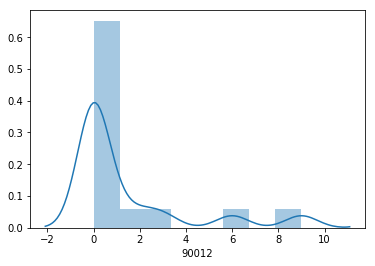

In [91]:
dist = sns.distplot((la_inb.T)[90012])